In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
from collections import deque
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import sys


In [14]:
# Ajouter le chemin du dossier parent (si besoin d'importer ScheduleEnv)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
from environment.schedule_env import ScheduleEnv

In [15]:
# 1. Chargement des données
df = pd.read_csv("../Data/processed/cleaned_data.csv")

In [16]:
# 2. Initialiser l'environnement
env = ScheduleEnv(df)
print(f"\n✅ Environnement créé avec {env.action_space.n} actions possibles")



✅ Environnement créé avec 18 actions possibles


c:\Users\Abdel\anaconda3\Lib\site-packages\gym\spaces\box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [17]:
# 3. Paramètres du DQN
state_size = 3
action_size = env.action_space.n
memory = deque(maxlen=2000)
batch_size = 32
gamma = 0.95
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995

In [18]:
# 4. Création du modèle DQN
model = tf.keras.Sequential([
    tf.keras.layers.Dense(24, input_dim=state_size, activation='relu'),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(action_size, activation='linear')
])
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(0.001))


c:\Users\Abdel\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
def update_plots(rewards, mean_rewards, epsilons, losses):
    ax1.clear()
    ax2.clear()
    
    ax1.plot(rewards, label='Récompense par épisode', alpha=0.4)
    ax1.plot(mean_rewards, label='Moyenne glissante (20)', color='red')
    ax1.set_title('Évolution des récompenses')
    ax1.set_xlabel('Épisode')
    ax1.set_ylabel('Récompense')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(epsilons, label='Epsilon', color='green')
    if losses:
        ax2.plot(losses, label='Perte (Loss)', color='orange')
    ax2.set_title("Évolution de l'epsilon et des pertes")
    ax2.set_xlabel("Épisode")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.draw()
    plt.pause(0.001)

In [21]:

# 6. Entraînement du DQN
def train_dqn(episodes=300):
    global epsilon
    rewards_history = []
    epsilons = []
    mean_rewards = []
    loss_history = []

    progress_bar = tqdm(range(episodes), desc="🔁 Entraînement DQN", unit="episode")

    for episode in progress_bar:
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        total_reward = 0
        done = False
        episode_loss = []

        while not done:
            if np.random.rand() <= epsilon:
                action = random.randrange(action_size)
            else:
                action = np.argmax(model.predict(state, verbose=0)[0])

            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])

            memory.append((state, action, reward, next_state, done))
            state = next_state
            total_reward += reward

            if len(memory) >= batch_size:
                minibatch = random.sample(memory, batch_size)
                states = np.array([x[0][0] for x in minibatch])
                actions = np.array([x[1] for x in minibatch])
                rewards = np.array([x[2] for x in minibatch])
                next_states = np.array([x[3][0] for x in minibatch])
                dones = np.array([x[4] for x in minibatch])

                targets = model.predict(states, verbose=0)
                next_q_values = model.predict(next_states, verbose=0)

                for i in range(batch_size):
                    if dones[i]:
                        targets[i][actions[i]] = rewards[i]
                    else:
                        targets[i][actions[i]] = rewards[i] + gamma * np.max(next_q_values[i])

                history = model.fit(states, targets, epochs=1, verbose=0)
                episode_loss.append(history.history['loss'][0])

        # Mise à jour epsilon
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        rewards_history.append(total_reward)
        epsilons.append(epsilon)
        loss_history.append(np.mean(episode_loss) if episode_loss else 0)

        # Moyenne glissante
        window_size = 20
        if episode >= window_size:
            mean_rewards.append(np.mean(rewards_history[-window_size:]))
        else:
            mean_rewards.append(np.mean(rewards_history))

        progress_bar.set_postfix({
            'Reward': f"{total_reward:.1f}",
            'Epsilon': f"{epsilon:.2f}",
            'AvgReward': f"{mean_rewards[-1]:.1f}",
            'Loss': f"{loss_history[-1]:.4f}" if episode_loss else "N/A"
        })

        if episode % 10 == 0:
            update_plots(rewards_history, mean_rewards, epsilons, loss_history)

    plt.ioff()
    plt.show()
    return rewards_history, mean_rewards, loss_history

In [22]:
# 7. Lancer l'entraînement
print("\n🚀 Début de l'entraînement...")
rewards, avg_rewards, losses = train_dqn(episodes=300)



🚀 Début de l'entraînement...


🔁 Entraînement DQN:   0%|          | 0/300 [00:00<?, ?episode/s, Reward=-1.2, Epsilon=0.99, AvgReward=-1.2, Loss=N/A]

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:   3%|▎         | 10/300 [00:31<15:59,  3.31s/episode, Reward=-0.1, Epsilon=0.95, AvgReward=1.0, Loss=9.4303]

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:   7%|▋         | 20/300 [01:04<15:41,  3.36s/episode, Reward=3.7, Epsilon=0.90, AvgReward=1.4, Loss=57.9210] 

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  10%|█         | 30/300 [02:00<29:52,  6.64s/episode, Reward=0.9, Epsilon=0.86, AvgReward=1.1, Loss=831.3562] 

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  13%|█▎        | 40/300 [03:02<28:51,  6.66s/episode, Reward=0.6, Epsilon=0.81, AvgReward=0.8, Loss=4237.1711] 

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  17%|█▋        | 50/300 [03:54<16:12,  3.89s/episode, Reward=-0.5, Epsilon=0.77, AvgReward=0.7, Loss=6177.3758]

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  20%|██        | 60/300 [04:27<13:27,  3.37s/episode, Reward=0.5, Epsilon=0.74, AvgReward=0.4, Loss=4623.1569] 

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  23%|██▎       | 70/300 [05:02<13:08,  3.43s/episode, Reward=3.4, Epsilon=0.70, AvgReward=0.2, Loss=2380.5593]  

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  27%|██▋       | 80/300 [05:38<13:04,  3.57s/episode, Reward=1.6, Epsilon=0.67, AvgReward=0.3, Loss=1143.5343] 

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  30%|███       | 90/300 [06:12<11:46,  3.37s/episode, Reward=-1.3, Epsilon=0.63, AvgReward=-0.2, Loss=1286.4577]

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  33%|███▎      | 100/300 [06:46<11:28,  3.44s/episode, Reward=-0.2, Epsilon=0.60, AvgReward=-0.3, Loss=496.6520]

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  37%|███▋      | 110/300 [07:18<10:16,  3.24s/episode, Reward=0.6, Epsilon=0.57, AvgReward=0.4, Loss=425.3530]  

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  40%|████      | 120/300 [07:51<09:40,  3.23s/episode, Reward=0.4, Epsilon=0.55, AvgReward=1.2, Loss=262.1591] 

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  43%|████▎     | 130/300 [08:25<09:20,  3.30s/episode, Reward=3.1, Epsilon=0.52, AvgReward=3.9, Loss=222.7524] 

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  47%|████▋     | 140/300 [09:00<08:43,  3.27s/episode, Reward=-1.5, Epsilon=0.49, AvgReward=6.1, Loss=133.2757]

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  50%|█████     | 150/300 [09:37<09:25,  3.77s/episode, Reward=-1.1, Epsilon=0.47, AvgReward=3.0, Loss=96.1244] 

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  53%|█████▎    | 160/300 [10:13<08:12,  3.52s/episode, Reward=2.8, Epsilon=0.45, AvgReward=1.8, Loss=119.1487] 

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  57%|█████▋    | 170/300 [10:49<07:41,  3.55s/episode, Reward=-0.6, Epsilon=0.42, AvgReward=4.2, Loss=47.3056]

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  60%|██████    | 180/300 [11:24<07:00,  3.50s/episode, Reward=0.5, Epsilon=0.40, AvgReward=3.1, Loss=34.2668] 

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  63%|██████▎   | 190/300 [11:59<06:32,  3.57s/episode, Reward=1.4, Epsilon=0.38, AvgReward=1.0, Loss=41.4625] 

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  67%|██████▋   | 200/300 [12:34<06:12,  3.72s/episode, Reward=-1.3, Epsilon=0.37, AvgReward=0.0, Loss=29.8950]

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  70%|███████   | 210/300 [13:31<09:06,  6.07s/episode, Reward=0.4, Epsilon=0.35, AvgReward=-0.4, Loss=21.3711] 

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  73%|███████▎  | 220/300 [14:27<07:12,  5.40s/episode, Reward=10.5, Epsilon=0.33, AvgReward=1.0, Loss=20.0818] 

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  77%|███████▋  | 230/300 [15:15<04:50,  4.15s/episode, Reward=14.2, Epsilon=0.31, AvgReward=6.1, Loss=13.7872]

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  80%|████████  | 240/300 [15:55<04:22,  4.37s/episode, Reward=11.0, Epsilon=0.30, AvgReward=8.2, Loss=10.4803]

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  83%|████████▎ | 250/300 [16:34<03:12,  3.85s/episode, Reward=4.0, Epsilon=0.28, AvgReward=5.2, Loss=10.2389] 

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  87%|████████▋ | 260/300 [17:14<02:41,  4.03s/episode, Reward=13.4, Epsilon=0.27, AvgReward=7.2, Loss=4.6563]

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  90%|█████████ | 270/300 [17:50<01:45,  3.51s/episode, Reward=9.5, Epsilon=0.26, AvgReward=10.6, Loss=2.7809] 

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  93%|█████████▎| 280/300 [18:25<01:10,  3.52s/episode, Reward=10.7, Epsilon=0.24, AvgReward=9.9, Loss=3.5989] 

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  97%|█████████▋| 290/300 [19:00<00:33,  3.30s/episode, Reward=10.6, Epsilon=0.23, AvgReward=8.2, Loss=2.9265]

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN: 100%|██████████| 300/300 [19:31<00:00,  3.90s/episode, Reward=12.9, Epsilon=0.22, AvgReward=6.9, Loss=3.7869]


In [23]:
# 8. Sauvegarde du modèle
os.makedirs("../models", exist_ok=True)
model.save("../models/dqn_final.h5")
print("\n✅ Modèle sauvegardé dans '../models/dqn_final.h5'")


✅ Modèle sauvegardé dans '../models/dqn_final.h5'


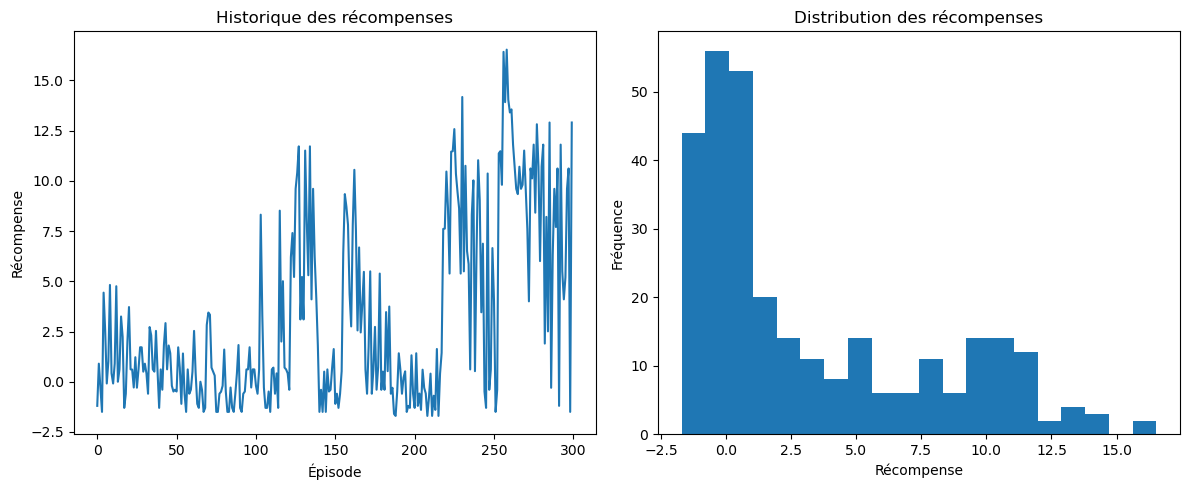

In [24]:
# 9. Visualisation finale
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(rewards)
plt.title("Historique des récompenses")
plt.xlabel("Épisode")
plt.ylabel("Récompense")

plt.subplot(1, 2, 2)
plt.hist(rewards, bins=20)
plt.title("Distribution des récompenses")
plt.xlabel("Récompense")
plt.ylabel("Fréquence")

plt.tight_layout()
plt.show()

In [26]:
import torch
torch.save(dqn_model.state_dict(), "trained_dqn_model.pth")

NameError: name 'dqn_model' is not defined